In [14]:
import pandas, os, re, sys, importlib, random, functools
import numpy as np

In [127]:
##################
# Orthology data.

if not os.path.exists('output/'):
    os.system('mkdir output/')

# This is a map of worm loci <-> human ENSG ids of orthologs.
orthos = orthoListHelper.orthoListHelper().read_ortholist_file('lib/OrthoList_20130531.csv', max_orthologs=2)
#print('gld-1 translation:', ortho_cmap.translate(input_id='T23G11.3', verbose=True))

Reading ortholist file, line:  0
Reading ortholist file, line:  1000
Reading ortholist file, line:  2000
Reading ortholist file, line:  3000
Reading ortholist file, line:  4000
Reading ortholist file, line:  5000
Reading ortholist file, line:  6000
Reading ortholist file, line:  7000
Have 794 Ensmbl language IDs in two gene sets...
language.complexTranslation info: {'Name': 'Unnamed complexTranslation object', 'gene sets a': 5188, 'gene sets b': 3911}


In [136]:



import write_excel
import language
import annotater
import fbfTargetSet
import targetSet
import complexTargetSet

import orthoListHelper
import pum2Helper
import fbfTargetHelper

importlib.reload(language)
importlib.reload(annotater)
importlib.reload(fbfTargetSet)
importlib.reload(targetSet)
importlib.reload(complexTargetSet)
importlib.reload(write_excel)
importlib.reload(orthoListHelper)
importlib.reload(pum2Helper)
importlib.reload(fbfTargetHelper)



def find_and_write_overlap_with_pum2(
        fbf, pum2_ensembl_ts, orthos, sheetname, writer):

    print('\nFinding overlap with PUM2 and {0}.'.format(sheetname))
    
    input_fbf_targets = len(fbf.fbf_cts.cgenes)
    
    fbf.fbf_cts.remove_nontranslatable_cgenes(orthos[2])  # orthos[2] is a worm loci<>ENSG translator.
    #fbf.fbf_cts.combine_targets_based_on_homology(orthos[2])
    table = fbf.fbf_cts.overlap_with_complexTargetSet(pum2_ensembl_ts, orthos[2], verbose=True)
    
    print('\nIdentified overlap with PUM2. Annotating the FBF targets and outputing to excel.')

    fbf_targs = fbf.annotate_fbf_targs_df(pum2_ensembl_ts, orthos)

    ann = annotater.annotater(
        pandas.read_csv('lib/OrthoList_20130531.csv', sep=','),
        name='Ortholist')

    ann.create_mapping('Locus ID')

    fbf_targs = ann.annotate_a_dataframe(fbf_targs, key='Locus ID')

    write_excel.write_tab3(fbf_targs, sheet_name=sheetname, writer=writer)

    fbf_targs.to_csv('output/fbf_targs_with_overlap.txt', index=False, sep='\t')
    
    print('\nWrote to excel. Finished comparing PUM2 and {0}.'.format(sheetname))
    
    table['Name'] = sheetname
    table['FBF targets input'] = input_fbf_targets
    return table

def simplify_locus_id(locus_id):
    
    txpt = locus_id.split('.')
    if len(txpt) > 1:
        locus_id = '.'.join(txpt[:2])
        
    return re.sub('[a-z]$', '', locus_id)






##################
# PUM2 targets.
# Get a complexTargetSet object of PUM2 targets translated to ENSG using the ortholist data.
# Only targets with worm homologs can be translated.
# This complexTargetSet object of PUM2 targets removes any ENSG without worm loci.
pum2_ensembl_ts = pum2Helper.pum2Helper().pum2_targets_as_ensembl(orthos)


##################
# Worm Gene name <-> Locus ID translator.
worm_translator = fbfTargetHelper.fbfTargetHelper().get_gene_name_locus_id_mapper(
    '/opt/lib/worm_txpt_id_gene_name_map.txt')
#print(worm_translator.translate(
#    input_id='gld-1', return_str=True, multiple_homologs_in_native_language_possible=False))


##################
# FBF targets.

top_dir = '/Users/dfporter/Desktop/macbook_air_Desktop/shared/sp_oo/FBF_gendered_gl/'
writer = pandas.ExcelWriter('output/File S7 conservation.xls')

overlap_table = []

all_fbf_targets = set()
file_sheet_name_tups = [
    (top_dir + '/tables/Table S1 Peaks.xls', 'OO FBF (25°C)'),
    (top_dir + '/tables/Table S1 Peaks.xls', 'SP FBF (25°C)'),
    (top_dir + '/tables/Table S1 Peaks.xls', 'OO FBF-1 (20°C)'),  
    (top_dir + '/tables/Table S1 Peaks.xls', 'OO FBF-2 (20°C)'),
    (top_dir + '/tables/Table S6 Blocks.xls', 'Block I'),
    (top_dir + '/tables/Table S6 Blocks.xls', 'Block II'),
    (top_dir + '/tables/Table S6 Blocks.xls', 'Block III'),
    ]

for fname, sheetname in file_sheet_name_tups:
    print("\n---\nLoading {0} - {1}".format(fname, sheetname))

    # Load file.
    if os.path.basename(fname).split('.')[-1] in ['xls', 'xlsx']:
        df = pandas.read_excel(fname, index_col=False, sheetname=sheetname)

        if ('transcript_id' not in df.columns) and ('Transcript' in df.columns):
            df['transcript_id'] = df['Transcript']

        elif ('transcript_id' not in df.columns) and ('Gene name' in df.columns):
            print('Using Gene name...')
            df['transcript_id'] = [worm_translator.translate(
                input_id=name, return_str=True, multiple_homologs_in_native_language_possible=False) \
                for name in df['Gene name']]

    print("Loaded file, finding overlaps.")
    all_fbf_targets |= set(df.transcript_id)

    overlap_table.append(find_and_write_overlap_with_pum2(
        fbfTargetSet.fbfTargetSet(input_df=df.copy()), pum2_ensembl_ts, orthos, sheetname, writer))

    # Top 500.
    if re.search('Table S1', fname):
        df.sort_index(by='Rank', inplace=True)
        
        genes_obs = set()
        gene_rank = []
        for gene in df.transcript_id:
            if len(gene):
                genes_obs.add(simplify_locus_id(gene))
            gene_rank.append(len(genes_obs))
            
        df['Gene rank'] = gene_rank
        print('Ranked {0} genes.'.format(len(genes_obs)))
        
        fbf = fbfTargetSet.fbfTargetSet(input_df=df[df['Gene rank']<501].copy())
        print('Check: {0} locus ids/{1} gene names simplified to {2}. -> top 500 -> {3}'.format(
            len(set(df['transcript_id'].tolist())), len(set(df['Gene name'].tolist())),len(genes_obs), 
            len(fbf.fbf_cts.cgenes)))
        
        overlap_table.append(find_and_write_overlap_with_pum2(
            fbf, pum2_ensembl_ts, orthos, sheetname + ' top 500', writer))
    
fbf = fbfTargetSet.fbfTargetSet(input_df=pandas.DataFrame({'transcript_id': list(all_fbf_targets)}))

overlap_table.append(find_and_write_overlap_with_pum2(
        fbf, pum2_ensembl_ts, orthos, 'All datasets', writer))

writer.save()

overlaps = pandas.DataFrame(overlap_table)



...Created a complexTargetSet (PUM2) in language Ensmbl:
{'Number of gene sets': 2580, 'Native language': 'Ensmbl', 'Name': 'PUM2'}
Total number of loci in ortholist: 7647. With translation to ESNGxx: 7639.
complexTranslation.qc(): All IDs are in one gene set.
Removing non-translatable genes: input 2580
...943 were translatable.

---
Loading /Users/dfporter/Desktop/macbook_air_Desktop/shared/sp_oo/FBF_gendered_gl//tables/Table S1 Peaks.xls - OO FBF (25°C)
Loaded file, finding overlaps.

...Created a complexTargetSet (FBF) in language Loci:
{'Number of gene sets': 1742, 'Native language': 'Loci', 'Name': 'FBF'}

Finding overlap with PUM2 and OO FBF (25°C).
Removing non-translatable genes: input 1742
...908 were translatable.
This complexTargetSet has 908 IDs of the form: frozenset({'K10B2.1'})
It's info is:
complexTargetSet info:  {'Number of gene sets': 908, 'Native language': 'Loci', 'Name': 'FBF'}

a_language_ids_with_translation (superset of a_targets): 5188, ex: "[frozenset({'M7.3

/Users/dfporter/Desktop/macbook_air_Desktop/shared/sp_oo/FBF_gendered_gl/orthos/write_excel.py:23: FutureWarning: by argument to sort_index is deprecated, pls use .sort_values(by=...)
  fbf_targs.sort_index(by=['Gene name'], inplace=True)
/Users/dfporter/pma/venv/lib/python3.6/site-packages/ipykernel_launcher.py:132: FutureWarning: by argument to sort_index is deprecated, pls use .sort_values(by=...)


...225 were translatable.
This complexTargetSet has 225 IDs of the form: frozenset({'R06F6.2'})
It's info is:
complexTargetSet info:  {'Number of gene sets': 225, 'Native language': 'Loci', 'Name': 'FBF'}

a_language_ids_with_translation (superset of a_targets): 5188, ex: "[frozenset({'Y52B11A.2'})]"
b_language_ids_with_translation (superset of b_targets): 3911, ex: "[frozenset({'ENSG00000166289', 'ENSG00000175895'})]"
a_targets_with_translations to lang b (unflattened): 225, ex: "[frozenset({'C33A12.3'})]"
b_targets_with_translations to lang a (unflattened): 943, ex: "[frozenset({'ENSG00000129083'})]"
a_targets_with_translations to lang b (flattened): 225, ex: "['B0240.4']"
all_a_target_ids in lang b after many<->many translation (flattened): 293, ex: "['ENSG00000145041']"
all_b_target_ids in lang b (flattened): 943, ex: "['ENSG00000082258']"

defaultdict(<class 'int'>, {'b_target_only': 1030, 'not_a_or_b_target': 3933, 'a_target_only': 135, 'shared_targets': 90})
Fisher 2x2 table= [[

Annotating by Locus ID...

Wrote to excel. Finished comparing PUM2 and OO FBF-2 (20°C).
Ranked 2194 genes.

...Created a complexTargetSet (FBF) in language Loci:
{'Number of gene sets': 500, 'Native language': 'Loci', 'Name': 'FBF'}
Check: 2234 locus ids/2194 gene names simplified to 2194. -> top 500 -> 500

Finding overlap with PUM2 and OO FBF-2 (20°C) top 500.
Removing non-translatable genes: input 500
...211 were translatable.
This complexTargetSet has 211 IDs of the form: frozenset({'B0414.5'})
It's info is:
complexTargetSet info:  {'Number of gene sets': 211, 'Native language': 'Loci', 'Name': 'FBF'}

a_language_ids_with_translation (superset of a_targets): 5188, ex: "[frozenset({'F57B10.11'})]"
b_language_ids_with_translation (superset of b_targets): 3911, ex: "[frozenset({'ENSG00000085511'})]"
a_targets_with_translations to lang b (unflattened): 211, ex: "[frozenset({'C09G9.6'})]"
b_targets_with_translations to lang a (unflattened): 943, ex: "[frozenset({'ENSG00000107485'})]"
a_


...Created a complexTargetSet (FBF) in language Loci:
{'Number of gene sets': 2000, 'Native language': 'Loci', 'Name': 'FBF'}
Removing non-translatable genes: input 2000
...1379 were translatable.
This complexTargetSet has 1379 IDs of the form: frozenset({'T07F10.4'})
It's info is:
complexTargetSet info:  {'Number of gene sets': 1379, 'Native language': 'Loci', 'Name': 'FBF'}

a_language_ids_with_translation (superset of a_targets): 5188, ex: "[frozenset({'F45D3.5'})]"
b_language_ids_with_translation (superset of b_targets): 3911, ex: "[frozenset({'ENSG00000204644'})]"
a_targets_with_translations to lang b (unflattened): 1379, ex: "[frozenset({'C05H8.1'})]"
b_targets_with_translations to lang a (unflattened): 943, ex: "[frozenset({'ENSG00000130856'})]"
a_targets_with_translations to lang b (flattened): 1379, ex: "['F56D1.4']"
all_a_target_ids in lang b after many<->many translation (flattened): 1602, ex: "['ENSG00000126698']"
all_b_target_ids in lang b (flattened): 943, ex: "['ENSG000

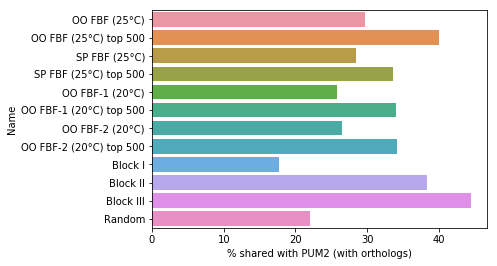

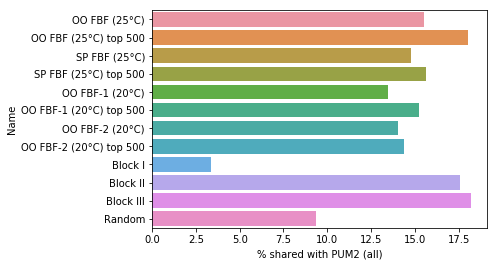

In [135]:
#overlap_table.append({})

def random_transcript_ids(orthos):
    locus_id_to_row, human_ensembl_to_locus_id, complexTransl = orthos
    sample = random.sample(list(locus_id_to_row.keys()), 2000)
    sample = [{'transcript_id': x} for x in sample]
    df = pandas.DataFrame(sample)
    fbf = fbfTargetSet.fbfTargetSet(input_df=df)
    fbf.fbf_cts.remove_nontranslatable_cgenes(orthos[2])
    #fbf.fbf_cts.combine_targets_based_on_homology(orthos[2])
    table = fbf.fbf_cts.overlap_with_complexTargetSet(pum2_ensembl_ts, orthos[2], verbose=True)
    table['Name'] = 'Random'
    print(table)
    overlap_table[-1].update(table)
    fbf.fbf_cts.stats()
#    print(sample)

random_transcript_ids(orthos)

overlaps = pandas.DataFrame(overlap_table)    

import seaborn as sns
import matplotlib.pyplot as plt

def refresh():
    plt.clf()
    plt.close()

overlaps['FBF_targets'] = [a+ab for a, ab in zip(overlaps.a_target_only, overlaps.shared_targets)]
overlaps['% shared with PUM2 (with orthologs)'] = [100*ab/t for ab, t in zip(overlaps.shared_targets, overlaps.FBF_targets)]

overlaps['% shared with PUM2 (all)'] = [100*ab/t for ab, t in zip(overlaps.shared_targets, overlaps['FBF targets input'])]

print(overlaps)

refresh()
sns.barplot(x='% shared with PUM2 (with orthologs)', y='Name', data=overlaps)
plt.show()
refresh()

sns.barplot(x='% shared with PUM2 (all)', y='Name', data=overlaps)
plt.show()
refresh()

In [ ]:
# Make the figure.
file_sheet_name_tups = [
    (top_dir + '/tables/Table S1 Peaks.xls', 'OO FBF (25°C)'),
    (top_dir + '/tables/Table S1 Peaks.xls', 'SP FBF (25°C)'),
    (top_dir + '/tables/Table S1 Peaks.xls', 'OO FBF-1 (20°C)'),  
    (top_dir + '/tables/Table S1 Peaks.xls', 'OO FBF-2 (20°C)'),
    (top_dir + '/tables/Table S6 Blocks.xls', 'Block I'),
    (top_dir + '/tables/Table S6 Blocks.xls', 'Block II'),
    (top_dir + '/tables/Table S6 Blocks.xls', 'Block III'),
    ]
overlaps, peaks = ({}, {})
for fname, sheetname in file_sheet_name_tups:
    overlaps[sheetname] = pandas.read_excel(fname, index_col=False, sheetname=sheetname)
    if re.search('Table S1', fname):
        peaks[sheetname] = pandas.read_excel(
            top_dir + '/tables/Table S1 Peaks.xls', index_col=False, sheetname=sheetname)

